In [182]:
import sys 

sys.path.append('./project_playground/QEC-with-spin-qubits/')

In [183]:
from RotatedSurfaceCode import RotatedSurfaceCode
from SurfaceCode3CX import SurfaceCode3CX
from XZZXCode import XZZXCode
from HeavyHEXFloquetColorCode import HeavyHexFloquetColorCode
from HeavyHEXHoneycombFloquetCode import HeavyHexHoneycombFloquetCode
from XYZ2Code import XYZ2Code
import plot_utils

import matplotlib.pyplot as plt
import numpy as np
import json
from scipy.optimize import fsolve
from math import comb


In [3]:
T1 = 3_300 #us
T2 = 50 #T2 of an idling qubit with arbitrary dynamical decoupling protocol 
Fidelity_RO = 0.99
Readout_time = 6
Fidelity_init = 0.995
Init_time = 2
Fidelity_1Q = 0.996
Fidelity_2Q = 0.996

pT1 = (1-np.exp(-(Readout_time+Init_time)/T1))/4 #relaxation, assuming exponential decay
pT2 = (1-np.exp(-(Readout_time+Init_time)**2/T2**2))/2 - (1-np.exp(-(Readout_time+Init_time)/T1))/4 #dephasing, assuming Gaussian decay
pRR = (1-Fidelity_RO)*Fidelity_init + (1-Fidelity_init)*Fidelity_RO
pG1 = 1-Fidelity_1Q
pG2 = 1-Fidelity_2Q

# pR = 15/31*pRR
f = lambda pR: sum([comb(2,i)*(8*pR/15)**i*(1-8*pR/15)**(2-i)*pR**j*(1-pR)**(1-j) for i in range(3) for j in range(2) if i+j%2])-pRR
pR = fsolve(f,pRR)[0]#inverting the formula of pRR(pR)
etaT = pT2/pT1
pT = pT1 + pT2
etaG= pG2/pG1
pG = (pG1 + pG2)/2
p_physR = np.sqrt(pG**2 + pT**2 + pR**2)
phi = np.arctan2(pT,pG)
thetaR = np.arctan2(pR,np.sqrt(pT**2 + pG**2))
p_physR

0.015105700467154518

UnboundLocalError: cannot access local variable 'e_connectivity' where it is not associated with a value

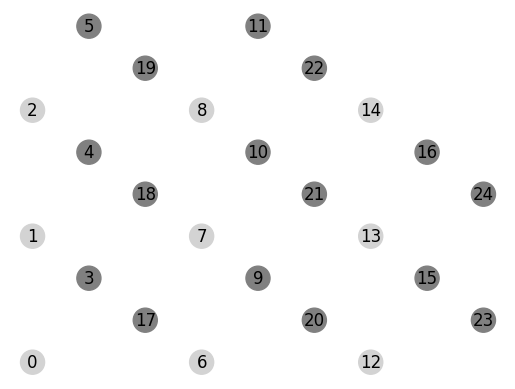

In [4]:
d: int = 3
T: int = 0
logical_observable: str = "Z"
gate_error_1q: float = pG1
gate_error_2q: float = pG2
idle_error_T1: float = pT1
idle_error_T2: float = pT2
measurement_error_rate: float = pRR
noisyLogRO: float = 1
# rsc = RotatedSurfaceCode(d=d,T=T,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate,noisyLogRO=noisyLogRO)

rsc = SurfaceCode3CX(d=d,T=T,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate)
rsc.draw_lattice()



In [7]:
di = 13
Ti = 13
rsc = SurfaceCode3CX(d=di,T=Ti,logical_observable=logical_observable,gate_error_1q=gate_error_1q,gate_error_2q=gate_error_2q,idle_error_T1=idle_error_T1,idle_error_T2=idle_error_T2,measurement_error_rate=measurement_error_rate)
# rsc.draw_lattice()

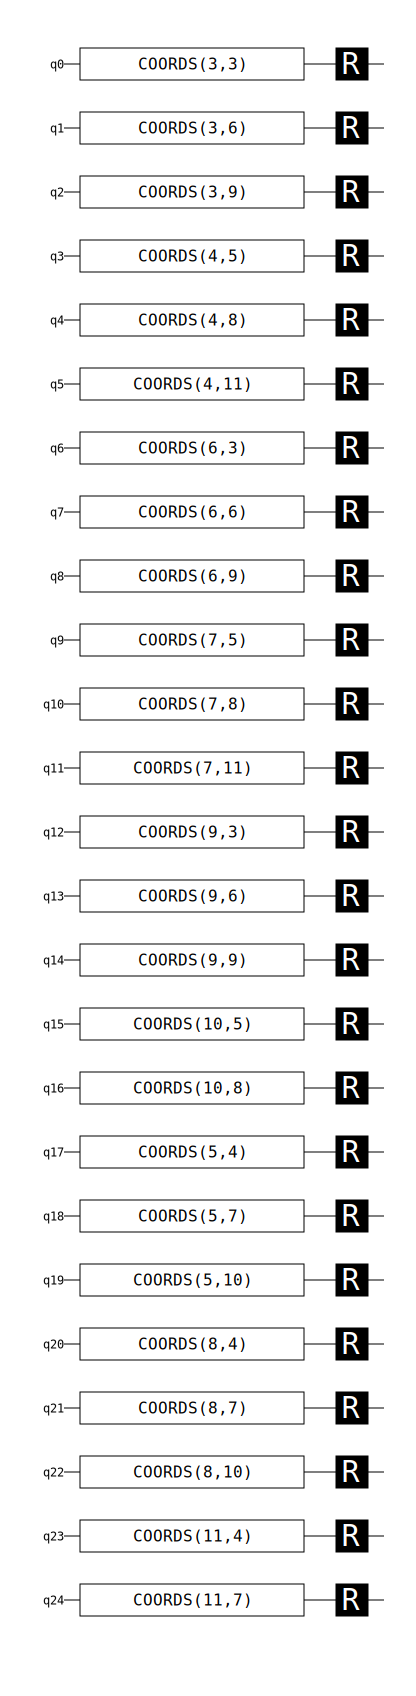

In [5]:
import stim



rsc.initialize_stim_circuit().diagram('timeline-svg')

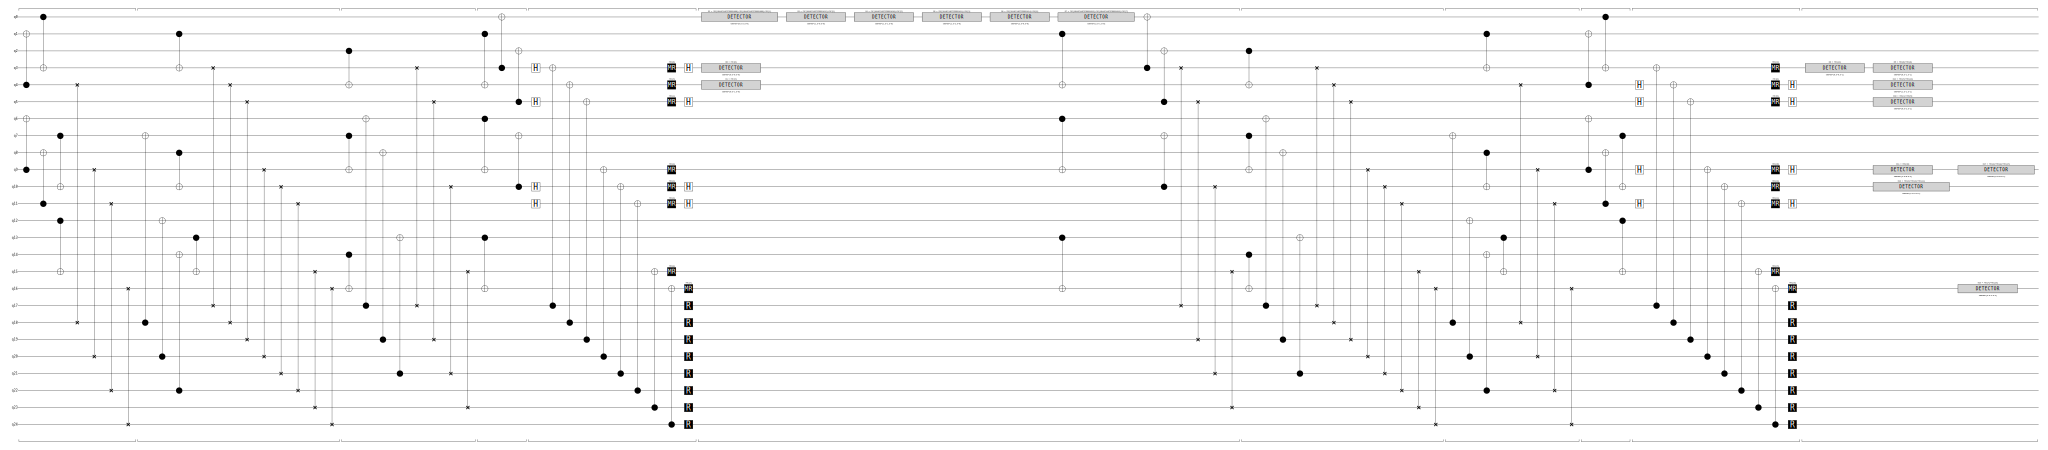

In [6]:
rsc.generate_stim_circuit_cycle().diagram('timeline-svg')

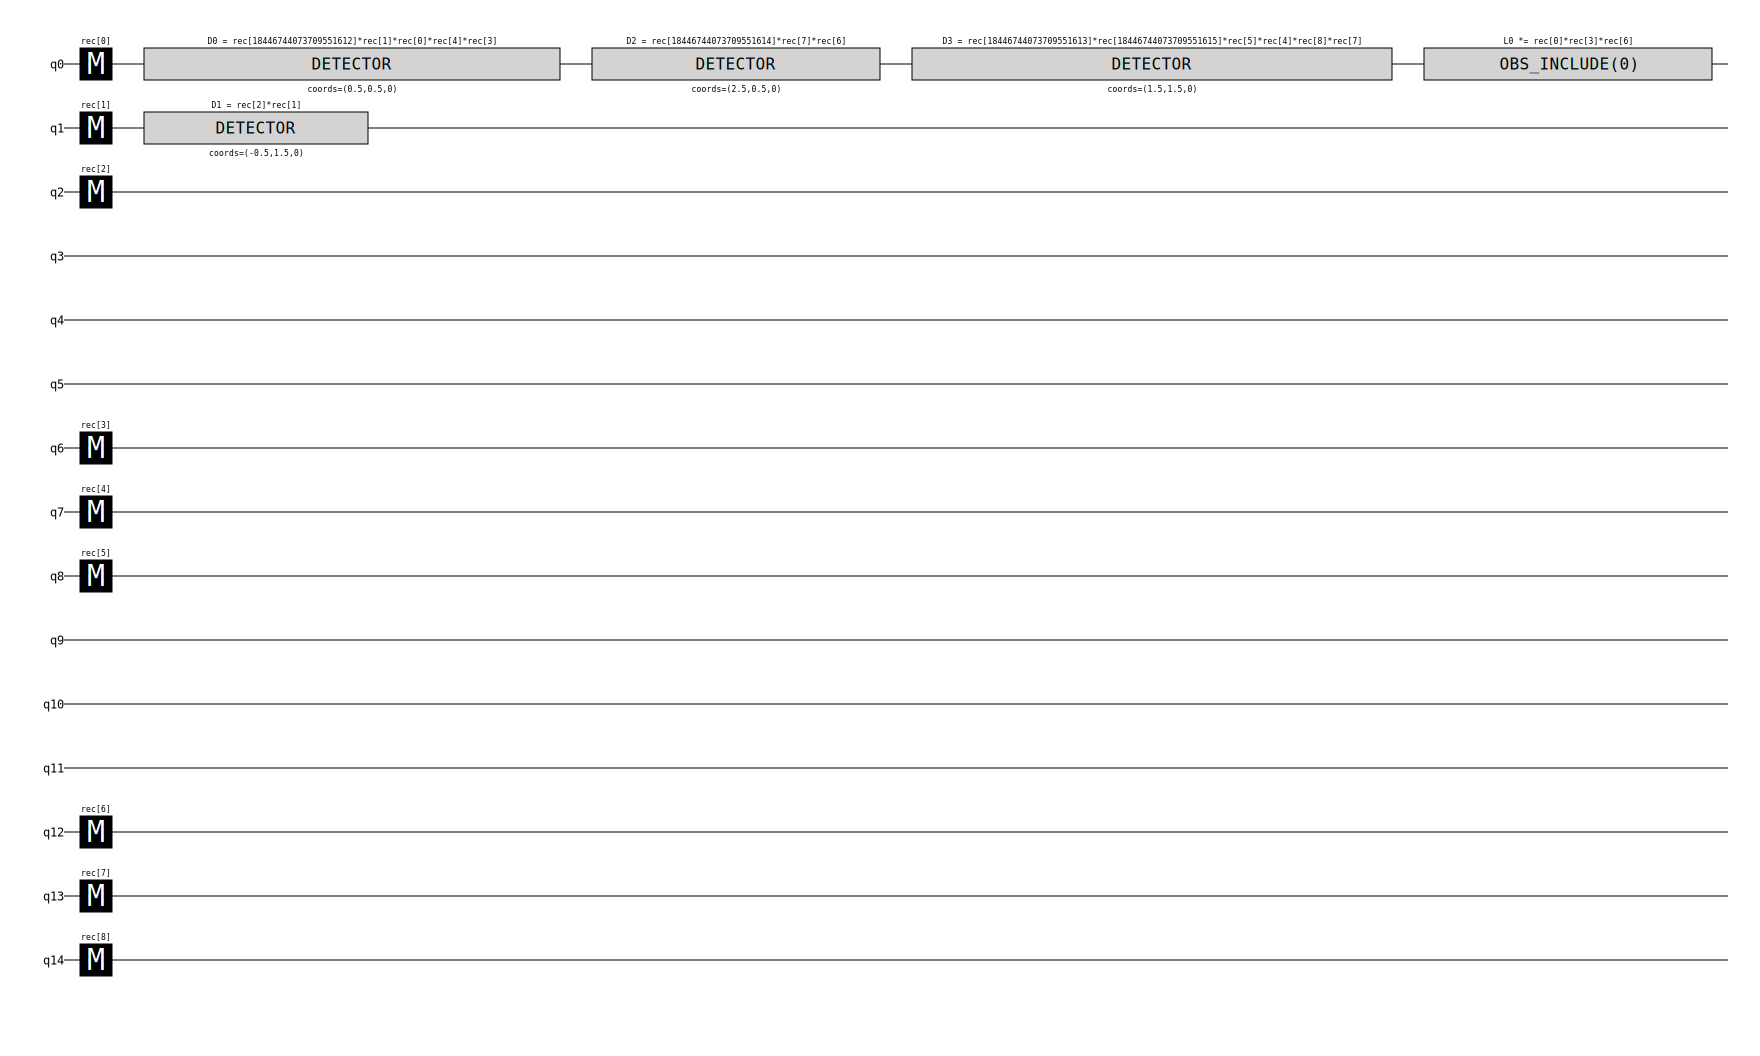

In [7]:
rsc.final_measurement_stim_circuit().diagram('timeline-svg')

In [8]:
num_shots = 50000

sampler = rsc.stim_circuit.compile_detector_sampler()
syndrome, actual_observables = sampler.sample(shots=num_shots, separate_observables=True)

# actual_observables.shape
import pymatching
model = rsc.stim_circuit.detector_error_model(decompose_errors=True,approximate_disjoint_errors=True)
matching = pymatching.Matching.from_detector_error_model(model)
# m = rsc.matching()
predicted_observables = matching.decode_batch(syndrome)
num_errors = np.sum(np.any(predicted_observables != actual_observables, axis=1))

print(num_errors,num_shots)  # prints 8
print(num_errors/num_shots)

1670 50000
0.0334


In [79]:
shots = 1000
m = rsc.matching()
num_fail = 0.0
num_correct = 0.0
sampler = rsc.stim_circuit.compile_detector_sampler()
syndrome,actual_observables = sampler.sample(shots=shots, separate_observables=True) 
# decoded = m.decode_batch(syndrome)
# preds = np.array([rsc.PredictedObservableOutcome(sample=d,m=m) for d in actual_observables])
# for sample in detector_samples:
#     actual_observable = sample[-1]
#     detectors_only = sample.copy()
#     detectors_only[-1] = 0
#     predicted_observable = rsc.PredictedObservableOutcome(sample=detectors_only,m=m)
#     num_fail += actual_observable != predicted_observable
#     num_correct += actual_observable == predicted_observable

# print(num_fail,num_correct)

# np.sum(decoded == preds)

ValueError: `shots` array should have at least 13 columns (the number of detectors), and no more than 14 columns (the number of nodes), but instead has 12 columns

In [15]:
theta,phi,Log_fail_d_p = plot_utils.LogFail_of_d_p(RotatedSurfaceCode, 
                                                    theta = 0, phi = 0, Gbias = 1, Tbias = 20, logical = 'X',
                                                    dist_list = range(11,17+1,2), error_list = np.linspace(0.001,0.03,10), T_over_d = 1,
                                                    max_shots = 10000, shot_batch = 100, max_num_fail = 1000, max_fail_rate = 0.4
                                                    )
p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
p_threshold

0.004267415228914087

In [12]:
list(range(11,18,2))

[11, 13, 15, 17]

In [29]:
circ = rsc.stim_circuit
# sim = stim.CompiledDetectorSampler(circ)
sim = stim.CompiledMeasurementSampler(circ)

# sim.sample(circ)

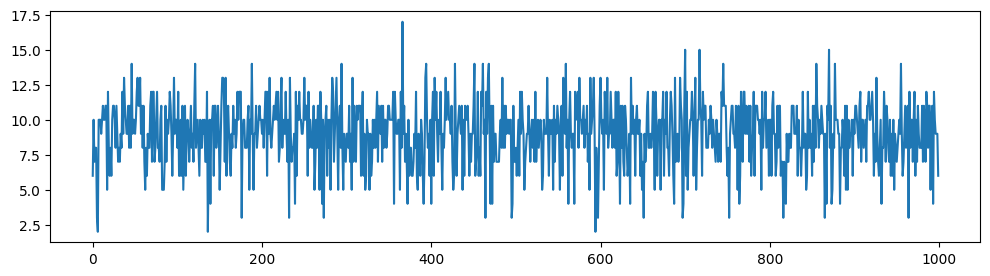

In [30]:
result = sim.sample(1000)

# for resulti in result:
#     plt.plot(result)
fig,ax = plt.subplots(1,1,figsize=(12,3))
ax.plot(np.sum(result,axis=1))

plt.show()

In [12]:
m = rsc.matching()
m.num_nodes

# dont run this for too large a graph

from itertools import product

for z in list(product([True,False],repeat=m.num_nodes)):
    print(z, ': ', rsc.PredictedObservableOutcome(z,m))


(True, True, True, True, True, True, True, True, True, True, True, True, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, True, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, True, False, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, True, False, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, False, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, False, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, True, False, False, True) :  1
(True, True, True, True, True, True, True, True, True, True, True, False, False, False) :  0
(True, True, True, True, True, True, True, True, True, True, False, True, True, True) :  1
(True, True, True, True, True, True, True, True, True, True, False, True, True, False) :  0
(True, True, True, True, True, True, True, True, True, True, False, True, False, True

In [157]:
from itertools import islice, zip_longest

def batched(iterable, n):
    "Batch data into lists of length n. The last batch may be shorter."
    # batched('ABCDEFG', 3) --> ABC DEF G
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            return
        yield batch

In [221]:
import sys
import plot_utils
import numpy as np
import json
import time
from multiprocessing import Pool

from RotatedSurfaceCode import RotatedSurfaceCode
from SurfaceCode3CX import SurfaceCode3CX
from XZZXCode import XZZXCode
from XYZ2Code import XYZ2Code
from HeavyHEXHoneycombFloquetCode import HeavyHexHoneycombFloquetCode
from HeavyHEXFloquetColorCode import HeavyHexFloquetColorCode

# Function moved to the global scope
def LogFail_of_d_p_arglist(arglist, code, Gbias, Tbias, logical, dmin, dmax, delpth, Num_p, max_shots, shot_batch, max_num_fail, max_fail_rate, ):
    return plot_utils.LogFail_of_d_p(
        code,
        theta=arglist[0], 
        phi=arglist[1], 
        Gbias=Gbias, 
        Tbias=Tbias, 
        logical=logical,
        dist_list=range(dmin, dmax + 2, 2), 
        error_list=arglist[2] * np.linspace(1. - delpth, 1. + delpth, Num_p), 
        T_over_d=1,
        max_shots=max_shots, 
        shot_batch=shot_batch, 
        max_num_fail=max_num_fail, 
        max_fail_rate=max_fail_rate, 
        # noisyLogRO=noisyLogRO
    )

def gen_surf_thresh_func_args(
    code=RotatedSurfaceCode,
    Nphi=20, 
    pGmax=0.007,
    pTmax=0.06, 
    pRmax=0.07, 
    noisyLogRO=False, 
    Num_p=30, 
    delpth=0.4, 
    Gbias=1, 
    Tbias=20, 
    dmin=11, 
    dmax=17, 
    logical='X', 
    max_shots=30000
):
    shot_batch = int(max_shots / 10)
    max_num_fail = int(max_shots / 10)
    max_fail_rate = 0.4
    slist = np.linspace(0, 1, Nphi)
    tlist = np.linspace(0,1,Nphi)
    # pG_list, pT_list, pR_list = np.transpose(
    #     [([pG, s * pTmax, (1 - s) * pRmax]) for s in slist]
    # )
    pG_list,pT_list,pR_list = np.transpose([([(1-s-t)*pGmax,s*pTmax,t*pRmax]) for s in slist for t in tlist if s+t<=1])
    print(len(pG_list), len(pT_list), len(pR_list))
    phi_list = np.arctan2(pT_list, pG_list)
    theta_list = np.arctan2(pR_list, np.sqrt(pT_list**2 + pG_list**2))

    p_threshold_guess = np.sqrt(pG_list**2 + pT_list**2 + pR_list**2)
    args = [
        (arglist, code,Gbias, Tbias, logical, dmin, dmax, delpth, Num_p, max_shots, shot_batch, max_num_fail, max_fail_rate, )
        for arglist in zip(theta_list, phi_list, p_threshold_guess)
    ]
    return LogFail_of_d_p_arglist, args


In [229]:

# # SC3
# code, dmax, logicals = [SurfaceCode3CX, '17', ['X','Z']]
# dmin=3 
# dmax=9 
# Tbias=20 
# Gbias=1 
# pGmax=0.007 
# pTmax=0.06 
# pRmax=0.04 
# Num_p=30 
# delpth=0.4 
# max_shots=300
# max_fail_rate=0.49 
# Nphi=20

# XZZX

# code, dmax, logicals = [XZZXCode, '17', ['X','Z']]
# dmin = 3
# dmax = 9
# Tbias=20 
# Gbias=1 
# pGmax=0.005 
# pTmax=0.18 
# pRmax=0.07 
# Num_p=30 
# delpth=0.5 
# max_shots=300
# max_fail_rate=0.45 
# Nphi=20

# # XYZ2
# code, dmax, logicals = [XYZ2Code, '17', ['Y','Z']]
# dmin = 3
# dmax = 9
# Tbias=20 
# Gbias=1 
# pGmax=0.0046
# pTmax=0.042
# pRmax=0.075 
# Num_p=30 
# delpth=0.3 
# max_shots=300
# max_fail_rate=0.4
# Nphi=20

# # FCC
# code, dmax, logicals = [HeavyHexFloquetColorCode, '17', ['X','Z']]
# dmin = 3
# dmax = 9
# Tbias=20 
# Gbias=1 
# pGmax=0.005
# pTmax=0.0065
# pRmax=0.0075
# Num_p=30 
# delpth=0.2
# max_shots=300
# max_fail_rate=0.45
# Nphi=20

# HFC
code, dmax, logicals = [HeavyHexFloquetColorCode, '17', ['X','Z']]
dmin = 3
dmax = 9
Tbias=20 
Gbias=1 
pGmax=0.0042
pTmax=0.012
pRmax=0.005
Num_p=30 
delpth=0.2
max_shots=300
max_fail_rate=0.45
Nphi=20

p = Pool(16)

func,args = gen_surf_thresh_func_args(code=code,max_shots=max_shots,logical=logicals[0],dmin=dmin,dmax=dmax,Tbias=Tbias,Gbias=Gbias,pGmax=pGmax,pTmax=pTmax,pRmax=pRmax,Num_p=Num_p,delpth=delpth)
result_X = p.starmap(func,args)

func,args = gen_surf_thresh_func_args(code=code,max_shots=max_shots,logical=logicals[1],dmin=dmin,dmax=dmax,Tbias=Tbias,Gbias=Gbias,pGmax=pGmax,pTmax=pTmax,pRmax=pRmax,Num_p=Num_p,delpth=delpth)
result_Z = p.starmap(func,args)


210 210 210
210 210 210


In [230]:
def result2sthreshs(result):
    LogZ_fail_3d_d_p = []
    for row in range(len(result)):        
        LogZ_fail_3d_d_p_col = []
        for col in range(len(result[row])):
            theta1, phi1, Log_fail_d_p = result[row][col]
            p_threshold, p_threshold_error = plot_utils.Threshold_from_LogFail(Log_fail_d_p)
            LogZ_fail_3d_d_p_col.append([theta1, phi1, p_threshold, p_threshold_error])
        LogZ_fail_3d_d_p.append(LogZ_fail_3d_d_p_col)
    return LogZ_fail_3d_d_p

LogX_fail_3d_d_p = result2sthreshs(list(batched(result_X,20)))
LogZ_fail_3d_d_p = result2sthreshs(list(batched(result_Z,20)))


In [231]:
import pickle

file_name1 = './HFC_3d_LogX_fail3d_d_p_300_3_9.pkl'
file_name2 = './HFC_3d_LogZ_fail3d_d_p_300_3_9.pkl'

with open(file_name1,'wb') as f:    
    pickle.dump(LogX_fail_3d_d_p,f)
with open(file_name2,'wb') as f:    
    pickle.dump(LogZ_fail_3d_d_p,f)
# with open(file_name1,'rb') as f:    
#     LogX_fail_3d_d_p = pickle.load(f)
# with open(file_name2,'rb') as f:    
#     LogZ_fail_3d_d_p = pickle.load(f)

In [232]:
sums = [0,0,0,0]

for i in range(len(result_X)):
    thing = result_X[i]
    for i,d in enumerate([3,5,7,9]):
        sums[i] += np.sum(thing[2][i][1])
        # print(thing[2][i][1])

In [233]:
sums

[561.4106630606569, 634.844960785631, 634.8108972194805, 580.1265011682013]

findfont: Font family 'times' not found.
findfont: Font family 'times' not found.


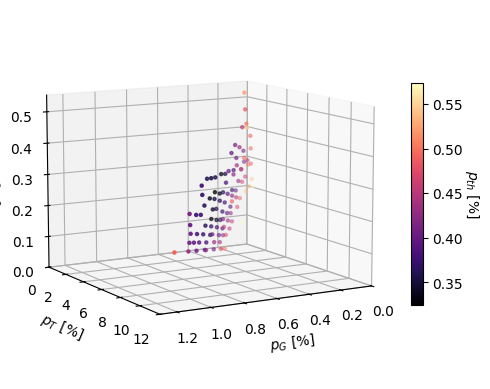

In [234]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
# pG = 0
# pT = 
# p_physRR = np.sqrt(pG**2 + pT**2 + pRR**2)
# thetaRR = np.arctan2(pRR,np.sqrt(pT**2 + pG**2))

poptlist,pfiterr,std,maxdev = plot_utils.fit_plane(LogX_fail_3d_d_p,LogZ_fail_3d_d_p)
plot_utils.plot_3d_threshold(LogX_fail_3d_d_p,LogZ_fail_3d_d_p,ax=ax,cmap='magma',truncate=False, alpha=0.,rescalepR=False)
# ax.set_xticks(np.arange(0,1.8,0.2))
ax.set_xlim(0,1.3)
ax.set_ylim(0,12)
ax.set_zlim(0,)
# fig.tight_layout()
ax.view_init(elev=10., azim=60)
plt.show()